<a href="https://colab.research.google.com/github/sn0422j/notebook/blob/master/brainspace_quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BrainSpace QuickStart

BrainSpaceは、Pythonで脳の勾配を計算し視覚化できるパッケージです。

> GitHub: https://github.com/MICA-MNI/BrainSpace  
Documentation: https://brainspace.readthedocs.io/en/latest/index.html

### BrainSpace のインストール

**pip** を使ってインストールできます。

In [1]:
!pip install brainspace

     |████████████████████████████████| 60.7MB 73kB/s 
     |████████████████████████████████| 103.4MB 58kB/s 


$!$ Google Colaboratry にはディスプレイが無く、別ウィンドウでのvtkのレンダリングができないので、**仮想ディスプレイ**を設定する必要があります。

In [2]:
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip install vtk pyvirtualdisplay

# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800, 200))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display)

### 勾配の計算

BrainSpaceでデータセットを読み込み、実際に勾配を計算しましょう。

**Conte69アトラス**という、人間の脳表面データを利用します。

In [3]:
from brainspace.datasets import load_conte69

# Load left and right hemispheres.
surf_lh, surf_rh = load_conte69()
print('Left hemisphere has {} points, and right hemisphere has {} points.'.format(surf_lh.n_points, surf_rh.n_points))

Left hemisphere has 32492 points, and right hemisphere has 32492 points.


脳表面データをプロットする関数もあります。

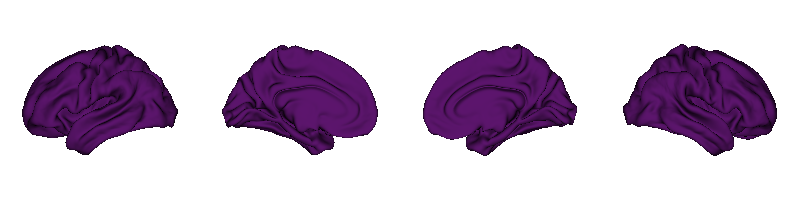

In [4]:
import numpy as np
from brainspace.plotting import plot_hemispheres

# Plot the surface data.
labeling = np.ones(surf_lh.n_points+surf_rh.n_points)
plot_hemispheres(surf_lh, surf_rh, array_name=labeling, size=(800, 200),
                 interactive=False, embed_nb=True)

Human Connectome Project (HCP) の安静時fMRIデータから計算した**連結性行列**（400個の領域間の類似度）を読み込みます。

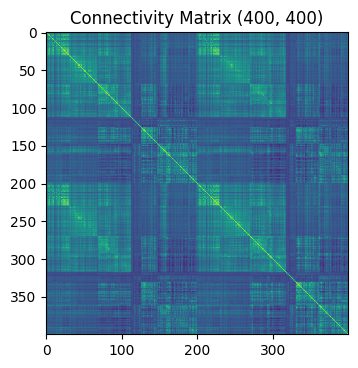

In [5]:
from brainspace.datasets import load_group_fc
import matplotlib.pyplot as plt

# Load the mean connectivity matrix.
Matrix = load_group_fc('schaefer', scale=400)

# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(Matrix)
ax.set_title('Connectivity Matrix {}'.format(Matrix.shape))
plt.show()

**勾配**を計算します。次の方法で、５つの因子を取得します。
- 類似度の計算方法：**正規化コサイン類似度 (Normalized angle similarity)**
- 低次元への変換方法：**拡散マップ (DM, Diffusion Mapping)**

GradientMaps(alignment=None, approach='dm', kernel='normalized_angle',
             n_components=5, random_state=0)


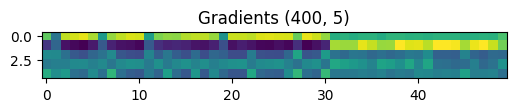

In [6]:
from brainspace.gradient import GradientMaps

# Build gradients using diffusion maps and normalized angle and fit to the data.
gm = GradientMaps(n_components=5, 
                  kernel='normalized_angle',
                  approach='dm',
                  random_state=0)
print(gm.fit(Matrix))

# Plot this gradients.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(gm.gradients_[:50].T)
ax.set_title('Gradients {}'.format(gm.gradients_.shape))
plt.show()

計算した**勾配の第１因子**を描画します。各領域の勾配値を脳表面にマッピングすることで描画することができます。

Gradients example: 
 [-0.11677493  0.03654031  0.0404199  -0.09630985  0.11842255]


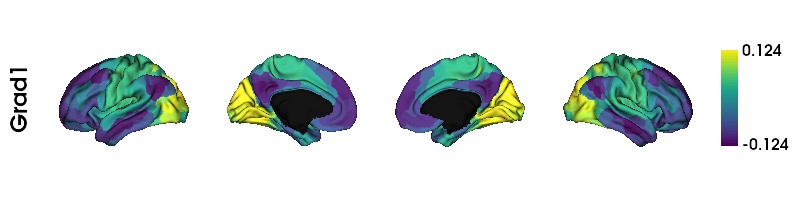

In [7]:
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels

# Map to original size
labeling = load_parcellation('schaefer', scale=400, join=True)
mask = labeling != 0
grad = map_to_labels(source_val=gm.gradients_[:, 0],
                     target_lab=labeling,
                     mask=mask, fill=np.nan)
print('Gradients example: \n {}'.format(grad[:5]))

# Plot on the surface.
plot_hemispheres(surf_lh, surf_rh, array_name=grad, size=(800, 200),
                 label_text=['Grad1'], color_bar=True,
                 interactive=False, embed_nb=True)

先行研究通りに、デフォルトモードネットワークから感覚領域への勾配がみられました。

### 集団間の比較

今度は、**被験者集団を２つに分けたときの勾配**を比較します。

集団間の勾配を揃えるために、**プロクラステス解析**を行います。

In [8]:
import numpy as np
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.gradient import GradientMaps

# Load the conte69 hemisphere surfaces
surf_lh, surf_rh = load_conte69()

# Load the connectivity matrix
Matrix1 = load_group_fc('schaefer', scale=400)
Matrix2 = load_group_fc('schaefer', scale=400, group='holdout')
labeling = load_parcellation('schaefer', scale=400, join=True)
mask = labeling != 0

# Build gradients
gm = GradientMaps(n_components=5, 
                  kernel='normalized_angle',
                  approach='dm',
                  alignment='procrustes', # Procrustes analysis
                  random_state=0)
print(gm.fit([Matrix1, Matrix2]))

GradientMaps(alignment='procrustes', approach='dm', kernel='normalized_angle',
             n_components=5, random_state=0)


計算した勾配を描画します。

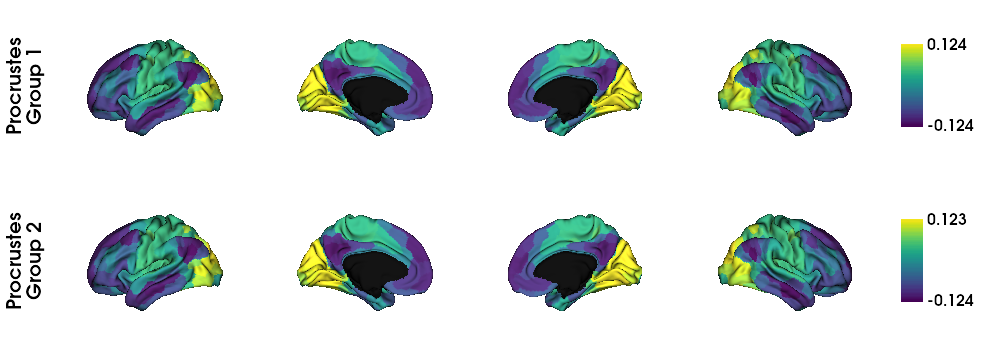

In [9]:
from brainspace.utils.parcellation import map_to_labels
from brainspace.plotting import plot_hemispheres

gradients_list = []
for i in range(2):
    gradients_list.append(map_to_labels(gm.aligned_[i][:, 0], labeling,
                                        mask=mask, fill=np.nan))

label_text = ['Procrustes\nGroup 1', 'Procrustes\nGroup 2']
plot_hemispheres(surf_lh, surf_rh, array_name=gradients_list, size=(1000, 350),
                 color_bar=True, label_text=label_text,
                 interactive=False, embed_nb=True)

この例では、集団間に大きな違いはありませんでした。

### まとめ
1. 連結性などを計算しておく。
```
Matrix = Compute_Connectivity(data)
```
2. 勾配を計算する。
```
GradientMaps(options).fit(Matrix)
```
3. 脳表面アトラスに描画する。
```
plot_hemispheres(surf_lh, surf_rh, labels)
```